# Imports

In [1]:
# standard imports
import numpy as np
import sys
import os
import random
import pandas as pd
import datetime

# imports for plotting
import matplotlib.pyplot as plt
from library import plotting

# Environment

In [2]:
%load_ext watermark
%watermark -a "Author: Nicole Königstein" 
%watermark -d -v -m 
%watermark -v -p numpy,pandas

Author: Nicole Königstein
2022-05-15 

CPython 3.9.12
IPython 7.19.0

compiler   : Clang 13.1.6 (clang-1316.0.21.2)
system     : Darwin
release    : 21.1.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
CPython 3.9.12
IPython 7.19.0

numpy 1.19.5
pandas 1.2.3


# Generate Synthetic Data

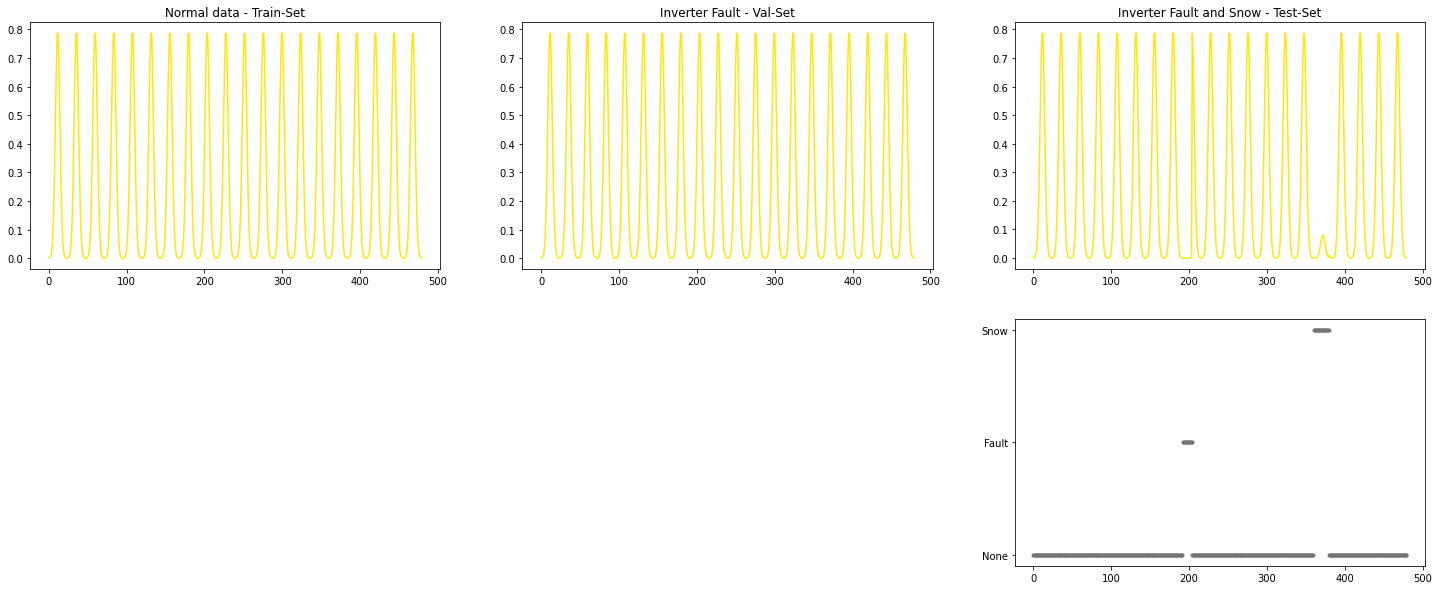

Saving figure:  synthetic_data


<Figure size 432x288 with 0 Axes>

In [3]:
def gaussian(x, b, c):
    """
    Creates a simple synthetic dataset to test an anomaly detection algorithm.

    """
    return 1/(np.sqrt(2*np.pi*c**2)) * np.exp(-1/2*((x-b)/c)**2)*4


def add_anomaly(timeseries, dict_anomalies):
    """
    Here you can add some anomalies. Currently are just two anomalies:
    "Fault and Snow" specific for the following paper:
    https://www.joao-pereira.pt/publications/accepted_version_ICMLA18.pdf

    """

    labels = np.array(['None']*len(timeseries), dtype="|U5")
    for time_range, type_ in dict_anomalies.items():
        if type_ == 'Fault':
            timeseries[time_range[0]:time_range[1]] = 0
        elif type_ == 'Snow':
            timeseries[time_range[0]:time_range[1]
                       ] = timeseries[time_range[0]:time_range[1]]*0.1

        labels[time_range[0]:time_range[1]] = type_

    return timeseries, labels


# define start and end point
t_start = -8
t_end = 8

################ define other time series parameter #######################
# time steps
n_timesteps = 24

# number of seasons to add to the time series.
n_seasons = 20
# gaussian paramter
b = 0
c = 2

# Just a random pattern
time = np.linspace(t_start, t_end, n_timesteps)
values = gaussian(time, b, c)

# Repeat the pattern as many times as set in n_seasons
seasonal = []
for i in range(n_seasons):
    for j in range(n_timesteps):
        seasonal.append(values[j])


# create val set
val_seasonal = np.array(seasonal)

# create test set
test_seasonal = np.array(seasonal)
test_anomalies = {(192, 204): 'Fault', (360, 380): 'Snow'}
test_seasonal, test_labels = add_anomaly(test_seasonal, test_anomalies)


# plot the created data
plt.figure(figsize=(25, 10))
plt.subplot(2, 3, 1)
plt.plot(seasonal, c='#fde70e')
plt.title('Normal data - Train-Set')

plt.subplot(2, 3, 2)
plt.plot(val_seasonal, c='#fde70e')
plt.title('Inverter Fault - Val-Set')

plt.subplot(2, 3, 3)
plt.plot(test_seasonal, c='#fde70e')
plt.title('Inverter Fault and Snow - Test-Set')

plt.subplot(2, 3, 6)
plt.plot(test_labels, '.', c='#757474')
plt.show()


# save the created data
plotting.save_fig('synthetic_data')

<AxesSubplot:>

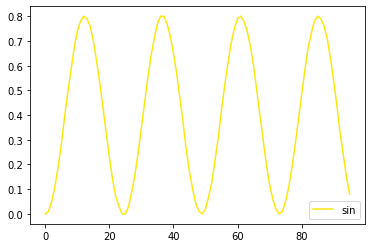

In [4]:
# variable for the data generation
day = 24 * 60 * 60
year = 365.2425 * day


def load_dataframe(year=year):
    """ 
    Creates a time series x sin wave dataframe for modelling
    a special time series for anomaly detection according to the following
    paper: https://www.joao-pereira.pt/publications/accepted_version_ICMLA18.pdf. 

    """

    df = pd.DataFrame(columns=['date', 'sin'])
    df.date = pd.date_range(start='2018-01-01', end='2018-02-01', freq='15min')
    df.sin = 1 + np.sin(df.date.astype('int64') // 1e9 * (2880 * np.pi / year))
    df.sin = (df.sin * 0.4).round(2)
    df.date = df.date.apply(lambda d: d.strftime('%Y-%m-%d-%H:%M'))

    return df


train_df = load_dataframe()

train_df_ = train_df[8:]
train_df_ = train_df_.reset_index(drop=True)
train_df_[:96].plot(c='#fde70e')

In [5]:
# validate the generated data (that indeed every 15 min is a timestamp)
train_df_.head(10)

,date,sin
0,2018-01-01-02:00,0.00
1,2018-01-01-02:15,0.01
2,2018-01-01-02:30,0.05
3,2018-01-01-02:45,0.11
4,2018-01-01-03:00,0.19
5,2018-01-01-03:15,0.28
6,2018-01-01-03:30,0.39
7,2018-01-01-03:45,0.49
8,2018-01-01-04:00,0.58
9,2018-01-01-04:15,0.67


<AxesSubplot:>

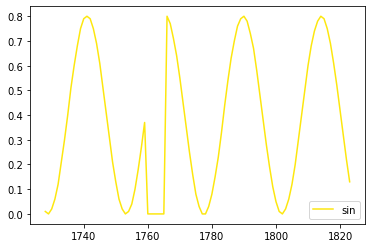

In [6]:
# just copy the test data and later at the anomalies
test_df = train_df_.copy()

# add the anomaly "inverter fault"
test_df.loc[1760:1765, ("sin")] = 0

# plot the result to verify
test_df[1728:1824].plot(c='#fde70e')

# Save the data

In [7]:
# save the first synthetic dataset

PATH = 'data'

# Training data
np.savetxt(PATH + '/train/data.txt', seasonal)

# Validation data
np.savetxt(PATH + '/val/data.txt', val_seasonal)

# Testing data
np.savetxt(PATH + '/test/data.txt', test_seasonal)
np.savetxt(PATH + '/test/labels.txt', test_labels, fmt='%s')

In [8]:
# save the second synthetic dataset

PATH = 'data2'

# Training data
np.savetxt(PATH + '/train/data.txt', train_df_['sin'].values)

# Validation data (just the same like the training data, with NO anomalies)
np.savetxt(PATH + '/val/data.txt', train_df_['sin'].values)

# Testing data
np.savetxt(PATH + '/test/data.txt', test_df['sin'].values)